Цель​ работы - освоить навыки работы с библиотекой TensorFlow Hub на
платформе Google Colaboratory для передачи обучения.
Задачи​:
1. Настроить среду для разработки на платформе Google Colaboratory.
2. Загрузить и подготовить набор данных с помощью TensorFlow
Datasets.
3. Загрузить и подготовить частичную модель MobileNet с Tensorflow
Hub.
4. Добавить слой классификации к частичной модели и обучить
полученную модель.
5. Визуализировать метрики и предсказания полученной модели.

## Подготовка окружения в google colab.

Установим необходимые библиотеки

In [ ]:
%tensorflow_version 1.x
!pip install tf-nightly-gpu
!pip install --upgrade gast==0.3.3
!pip install tensorflow_hub==0.4.0
!pip install tensorflow-datasets==3.2.1

Импортируем их.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import PIL.Image as Image

Установим необходимый уровень вывода сообщений об ошибках.

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## 1. Использование TensorFlow Hub MobileNet для предсказаний.

В данной работе в качестве данных используются различные изображения, на которых представлены животные, люди.

### Загружаем MobileNet-нейросеть и создаем из неё модель в фреймворке Keras.

In [ ]:
# укажем ссылку на модель
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

# модель требует на вход именно это разрешение
IMAGE_RES = 224

model = tf.keras.Sequential([
                            hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES,3))
]) 

Загрузим изображение и выведем его.

In [ ]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

Нормировка изображения, перед подачей его на вход сети.

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

Получение предсказания, отдельно стоит обратить внимание, на то, что сеть по умолчанию дает на выходе тензор размерность 1001, это связано с тем, что исходно сеть обучена на датасете ImageNet, в котором 1000 классов

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

По индексу с максимальным значением получим класс, к которому по выходу нейросети, принадлежит искомое изображение.

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Расшифровка предсказания

В ячейке ниже мы хотим понять, какое предсказание в итоге дала нейросеть.

Для этого:

- загрузим список меток Imagenet (поскольку сеть обучалась на этом датасете)
- по полученному классу, сопоставим номер класса с текстовым описанием.

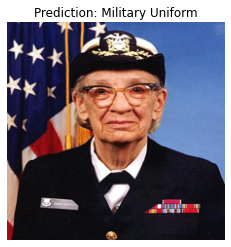

In [9]:
# загрузим метки
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


# выведем изображение
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Модель корректно определила военную форму.

## 2. Использование TensorFlow Hub-модели для набора данных лошадей и людей

Перед тем как дообучать сеть под нашу конкретную задачу (распознавание людей и конец), проверим какие результаты штатная версия MobileNet даст на этом датасете, возможно и не потребуется подстраивать сеть.

Воспользуемся TensorFlow Datasets для загрузки набора данных лошадей и людей.

In [10]:
# загрузим датасет, возьмем для обучающего набора данных 80% исходных изображений
# для валидации - 20%
splits, info = tfds.load('horses_or_humans', with_info=True, as_supervised=True, split = ['train[:80%]', 'train[80%:]'],)
(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

# выведем количество изображнений / классов
print(num_examples, num_classes)

    'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
1027 2


По итогу получаем 1027 изображений, 2 класса - человек, лошадь.

Проверим, в каком разрешении картинки в датасете.

Часто они могут быть в любом разрешении (в каком собрали, в таком и хранится).

In [11]:
# выведем первые три картинки из обучающей выборки
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (300, 300, 3)
Image 2 shape: (300, 300, 3)
Image 3 shape: (300, 300, 3)


Тем не менее необходимо привести изображения к единому размеру, который ожидает на входе модель MobileNet - 224 x 224.

In [12]:
# создадим функцию которая будет подгонять изображение под нужное разрешение и нормировать его
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

# определим размер батча в 32 изображения, т.е. на вход будет подан тензор размером 32х224х224х3, где 3-кол-во каналов
BATCH_SIZE = 32

# разобъем на батчи
# батч - пакет с картинками (данными)
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Запуск сети на наборах изображений

При обучении нейросети сеть учим качественно выделять обобщяющие признаки на большом количестве изображений.

Суть механизма transfer learning состоит в том, что один раз научив сеть хорошо выделять признаки, мы можем это "умение", переносить на другие задачи путем небольшой коррекции (дообучения) на нашей задаче.

Предобученная MobileNet содержит 1 000 возможных выходных классов. 
ImageNet это датасет, содержащий большое количество изображений людей и лошадей, поэтому можно попробовать подать на вход одно из тестовых изображений из выбранного набора данных и посмотреть, какое предсказание даст модель.

Возьмем одну пачку изображений и прогоним её через сеть.

In [13]:
# Берем батч
image_batch, label_batch = next(iter(train_batches.take(1)))

# приводим их к типу - массив нампай
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

# делаем предикт
result_batch = model.predict(image_batch)

# сопоставляем метки классов их текстовым описаниям
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Great Dane', 'sorrel', 'Ibizan hound', 'Rhodesian ridgeback',
       'sorrel', 'jean', 'sorrel', 'Great Dane', 'whippet', 'jersey',
       'jean', 'jean', 'torch', 'oxcart', 'cowboy boot', 'sandbar',
       'whippet', 'Mexican hairless', 'maillot', 'bluetick', 'hartebeest',
       'sandbar', 'bow', 'sandbar', 'maillot', 'flat-coated retriever',
       'seashore', 'sorrel', 'Mexican hairless', 'ram', 'horizontal bar',
       'swimming trunks'], dtype='<U30')

Как видно, метки похожи на названия пород лошадей и других объектов, представленных на выбранных изображениях. 

Выведем несколько изображений, с их метками.

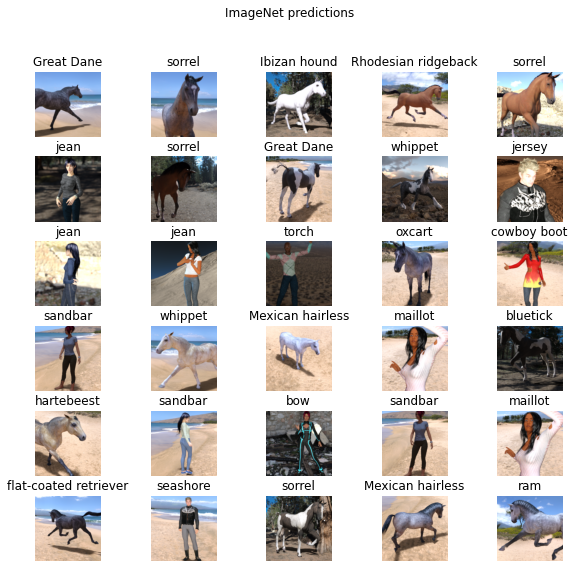

In [14]:
plt.figure(figsize=(10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Как видно, в целом сеть предсказывает в большом количестве случаев вполне осмысленные результаты, которые не являются верными в контексте датасета люди и лошади.

## 3. Реализация передачи обучения с TensorFlow Hub

Теперь переобучем MobileNet при помощи TensorFlow Hub.

В процессе передачи обучения использую предобученную модель, но с тем условим, что изменим её последний слой / несколько слоев.

В TensorFlow Hub можно найти не только полные предобученные модели (с последним слоем), но и модели без последнего классификационного слоя. Последние могут быть легко использованы для передачи обучения. В рамках данной практики продолжить использовать MobileNet v2. 

Стоит отметить, что частичная модель с TensorFlow Hub (без последнего классификационного слоя) названа `feature_extractor`. 

Объясняется это наименование тем, что модель принимает на вход данные и преобразует их до конечного набора выделенных свойств (характеристик). 

Таким образом модель выполняет работу по идентификации содержимого изображения, но не производит финального распределения вероятностей по выходным классам. Модель извлекает набор свойств из изображения.

In [15]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

Пропустим через такую сеть `feature_extractor` набор изображений и посмотреть на выходной тензор. 

32 - количество изображений в батче, 1280 - количество нейронов на последнем слое предобученной модели с TensorFlow Hub.

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Заморозим все слои сети.
По сути, при этом изменении во всех слоях сети, кроме последнего замораживаются веса.

In [17]:
feature_extractor.trainable = False

### Добавление слоя классификации

Обернем слой из нашего `feature_extractor` в `tf.keras.Sequential` модель и добавим классификационный слой.

Из Keras добавим Dense-слой с выходным количеством нейронов - 2, что будет соответствовать двум нашим классам, лошади и люди.

In [18]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])


# выведем нашу итоговую модель
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Обучение модели

Обучим полученную модель, вызывая `compile` с последующим `fit` для тренировки.

Compile - укажем метод оптимизации параметров, лосс-функцию, метрику, fit - для запуска процесса обучения.

Добавим еще коллбек на сохранением лучших весов по функции потерь, для того, чтобы взять наилучшую модель за все время обучения.

Это также позволит частично решить проблему переобучения.

In [19]:
checkpoint_filepath = '/tmp/checkpoint'

# укажем необходимые параметры
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# создадим коллбек
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# укажем количество эпох обучения, и запустим процесс
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[model_checkpoint_callback])

Epoch 1/6
26/26 [==============================] - 9s 332ms/step - loss: 0.4542 - acc: 0.8528 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
26/26 [==============================] - 5s 176ms/step - loss: 0.1656 - acc: 0.9915 - val_loss: 0.1110 - val_acc: 0.9951
Epoch 3/6
26/26 [==============================] - 5s 177ms/step - loss: 0.1278 - acc: 0.9976 - val_loss: 0.1034 - val_acc: 0.9951
Epoch 4/6
26/26 [==============================] - 5s 178ms/step - loss: 0.1135 - acc: 0.9988 - val_loss: 0.0992 - val_acc: 1.0000
Epoch 5/6
26/26 [==============================] - 5s 177ms/step - loss: 0.1064 - acc: 1.0000 - val_loss: 0.0964 - val_acc: 1.0000
Epoch 6/6
26/26 [==============================] - 5s 177ms/step - loss: 0.1019 - acc: 1.0000 - val_loss: 0.0949 - val_acc: 1.0000


Для нейросети эпоха - это когда весь датасет (все батчи), прошли через сеть в прямом и обратном проходе 1 раз.

In [20]:
# загрузим лучшие веса
model.load_weights(checkpoint_filepath)

Выведем графики изменения значений точности и потерь на обучающем и валидационном наборах данных.

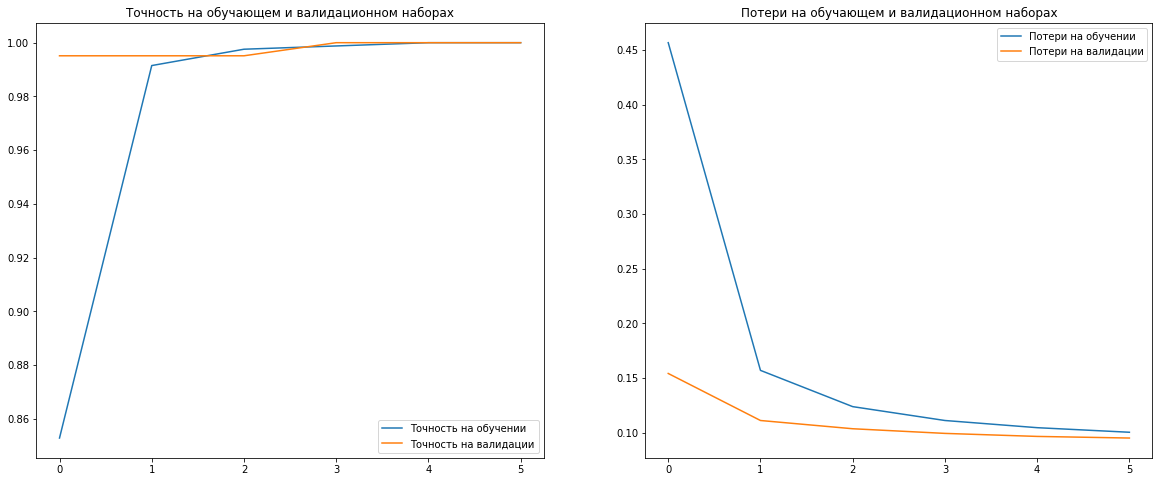

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающем и валидационном наборах')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающем и валидационном наборах')
plt.show()

Как видно из графиков, сеть быстро научилась различать людей и лошадей на изображениях.

Это происходит потому, что ранее, при обучении под-сети MobileNet она уже обучалась на большом наборе лошадей и людей.

Также, требуется отметить, что результаты на валидационном наборе данных лучше результатов на обучающем наборе данных с самого начала до самого конца процесса обучения.

Это происходит, потому, что точность на валидационном наборе данных измеряется в конце обучающей итерации, а точность на тренировочном наборе данных считается как среднее значение среди всех обучающих итераций.

## 4. Проверка результатов предсказаний

Для начала получим отсортированный список наименований классов:

In [22]:
info.features['label'].names

['horses', 'humans']

In [23]:
class_names = np.array(info.features['label'].names)
class_names

array(['horses', 'humans'], dtype='<U6')

Пропустим блок с изображениями через модель и сопоставим полученные индексы в с именами классов:

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['horses', 'horses', 'horses', 'horses', 'horses', 'humans',
       'horses', 'horses', 'horses', 'humans', 'humans', 'humans',
       'humans', 'horses', 'humans', 'humans', 'horses', 'horses',
       'humans', 'horses', 'horses', 'humans', 'humans', 'humans',
       'humans', 'horses', 'humans', 'horses', 'horses', 'horses',
       'humans', 'humans'], dtype='<U6')

Сравнить истинные и предсказанные метки:

In [25]:
print('{:<15}'.format("Метки: "), label_batch)
print('{:<15}'.format("Предсказания: "), predicted_ids)

Метки:          [0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1]
Предсказания:   [0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1]


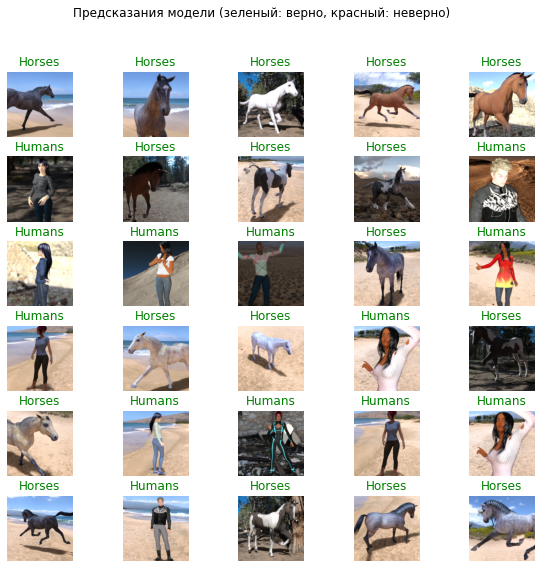

In [26]:
plt.figure(figsize=(10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = "green" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Предсказания модели (зеленый: верно, красный: неверно)")

Как видно, в картинки с метками совпадают, что позволяет делать вывод о том, что сеть научилась правильно определять классы.

Посмотрим по метрике binary accuracy, на результат предсказаний модели.

In [27]:
batch_accuracy = []
for batch in validation_batches:
  predicted_batch = model.predict(batch)
  predicted_batch = tf.squeeze(predicted_batch).numpy()
  predicted_ids = np.argmax(predicted_batch, axis=-1)
  true_ids = np.array(batch[1])
  batch_accuracy.append((predicted_ids == true_ids).sum() / true_ids.shape[0])


result_accuracy = np.array(batch_accuracy).mean() * 100

print(f"Итоговая точность на валидационной выборке составляет %.0f %%" % result_accuracy)

Итоговая точность на валидационной выборке составляет 100 %


## Заключение


В этой работе были выполнены следующие пункты:

1. настроили окружение в google colab, установили и импортировали необходимые пакеты.

   на самом первом этапе встретились некоторые трудности, связанные с несовместимостью версий в колабе с исходными импортами (которые были даны в задании к работе)

2. Загрузили и подготовили датасет horse ans humans, а именно изображения перевели в размер 224х224 (требуется на вход в MobileNet), нормировали их, и затем разбили на батчи.

3. Скачали преобученную модель MobileNet, убрали из нее штатную "голову", которая выполняла классификацию по 1000 классам и заменили её на слой, с двумя выходными нейронами (что требуется в нашей задаче).

5. Обучили модель на датасете horse ans humans и измерили метрики качества, как и ожидалось, для такой простой задачи сеть очень быстро обучилась (для приемлего качаства сеть смогла обучиться за 3-4 эпохи).

  Построили кривые качества (точность и значения функции потерь) на тестовом и валидационном наборе данных.

   Также отдельно посчитали, какое же качество по метрике binary accuracy выдает сеть на валидационном наборе данных с лучшими весами, как оказалось это результат в 100%.